## Imports

In [5]:
import os
import glob
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint
from torchdyn.core import NeuralODE

from tqdm import tqdm
from natsort import natsorted
from collections import Counter

## CUDA Setup

In [6]:
print(f"Torch version: {torch.__version__}")
print(f"Torch cuda version: {torch.version.cuda}")

Torch version: 2.6.0
Torch cuda version: 12.6


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Dataset Initialization

In [8]:
def collate_fn(batch): # Sett til alltid å være 180
    '''
    Pads the trajectories such that they all have the same length as the longest one (e.g. 178)
    '''
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths
    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        "observations": padded_obs
    }

In [9]:
dataset = minari.load_dataset('D4RL/pointmaze/umaze-v2')
print(f"Total amount of episodes: {dataset.total_episodes}") 
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
print(f"Length of dataLoader (total episodes/batch_size): {len(dataLoader)}")

for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

Total amount of episodes: 13210
Length of dataLoader (total episodes/batch_size): 206
test_batch.shape: torch.Size([64, 176, 4])


In [10]:
x_start = test_batch[:, 0, :]   # Initial points
x_end = test_batch[:, -1, :]    # Final points

# Compute standard deviation of displacement
sigma_init = 0.5 * torch.std(x_end - x_start).item()  # Scale by 0.5 as a heuristic

print("Initial sigma:", sigma_init)
# sigma_init = 0.0

Initial sigma: 1.5621459650880076


## Dataset Trajectory Examples

In [11]:
print(test_batch[0].shape)
print(test_batch[0, :, 0].shape)
print(len(test_batch[1]))

torch.Size([176, 4])
torch.Size([176])
176


In [12]:
observation_lst = []
max_batches = 30
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

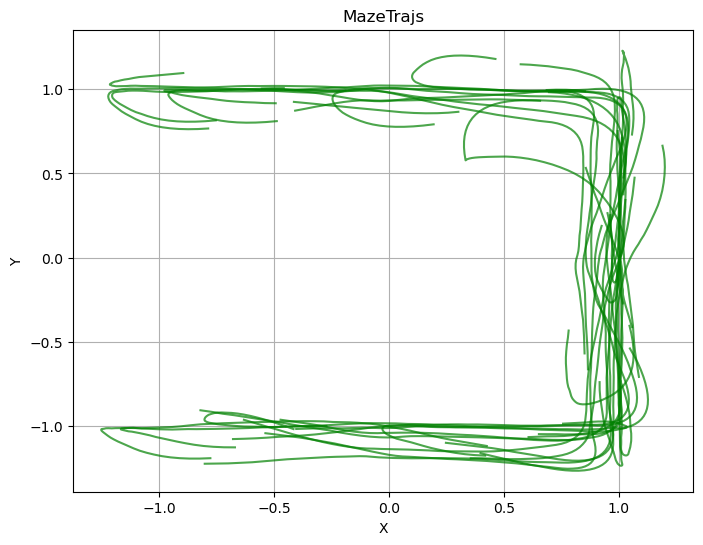

In [13]:
plt.figure(figsize=(8, 6))
for observations in observation_lst:
    plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.7)
plt.title('MazeTrajs')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

Total duplicate points 1: 1, 2: 1, the final one
Duplicate points and their counts: 1: {(np.float64(-0.36843933293214254), np.float64(-1.0269935175031615)): 100}  2:  {(np.float64(-0.3998507343242371), np.float64(0.9141329851277034)): 29}


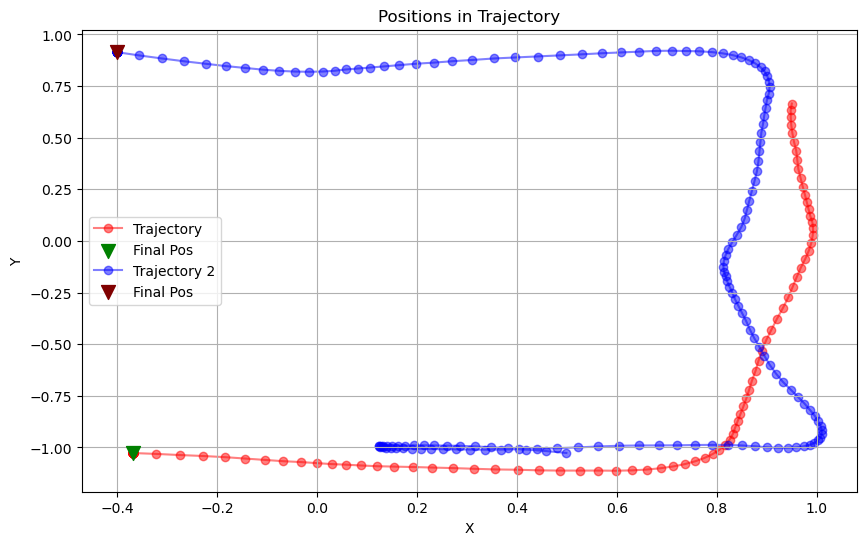

In [14]:
idx = 0 

trajectory = test_batch[idx].cpu().numpy()
trajectory_2 = test_batch[idx+1].cpu().numpy()
traj_tuples = [tuple(point[:2]) for point in trajectory]  # Only (x, y) positions
traj_tuples_2 = [tuple(point[:2]) for point in trajectory_2]  # Only (x, y) positions

# Count occurrences
counts = Counter(traj_tuples)
counts_2 = Counter(traj_tuples_2)

# Filter duplicates (points appearing more than once)
duplicates = {point: count for point, count in counts.items() if count > 1}
duplicates_2 = {point: count for point, count in counts_2.items() if count > 1}

print(f"Total duplicate points 1: {len(duplicates)}, 2: {len(duplicates_2)}, the final one")
print("Duplicate points and their counts: 1:", duplicates, " 2: ", duplicates_2)

plt.figure(figsize=(10, 6))

plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color='red', alpha=0.5, label="Trajectory", zorder=1)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], marker='v', color='green',s=100, alpha=1, label="Final Pos", zorder=2)

plt.plot(trajectory_2[:, 0], trajectory_2[:, 1], marker='o', color='blue', alpha=0.5, label="Trajectory 2", zorder=1)
plt.scatter(trajectory_2[-1, 0], trajectory_2[-1, 1], marker='v', color='maroon',s=100, alpha=1, label="Final Pos", zorder=2)

plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

## Trajectory Flow Matching Model

In [15]:
class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=512, num_layers=5): # Samme som Lipman
        """
        A neural network that estimates the velocity field for flow matching.

        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()

        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            
            # Alternating activation functions for better gradient flow and expressivity
            if i % 2 == 0:
                layers.append(nn.SiLU())  # Swish/SiLU for smoothness
            else:
                layers.append(nn.ReLU())  # ReLU for stability
            
            input_dim = hidden_dim 
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output layer, no activation
        self.network = nn.Sequential(*layers)

    def forward(self, xt):
        """
        Forward pass for the trajectory flow model.
        """
        velocity = self.network(xt) 
        return velocity

In [16]:
lr = 3e-3
obs_dim = 2
flow_model = TrajectoryFlowModel(obs_dim).to(device)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)

## TFM Functionality Check

In [17]:
# Define input tensor
batch_size = 64 
obs_dim = 4
xt = torch.randn(batch_size, obs_dim + 1).to(device, dtype=torch.float32)  # Adding time `t` as an input feature

# One pass
velocity_pred = flow_model(xt)

# Shapes:
print(f"Input shape: {xt.shape}")  # Expected: (64, 5)
print(f"Output shape: {velocity_pred.shape}")  # Expected: (64, 4)

# Define a dummy target velocity tensor
target_velocity = torch.randn_like(velocity_pred)

# Loss
loss_fn = nn.MSELoss()
loss = loss_fn(velocity_pred, target_velocity)
loss.backward()

# Are the gradients computed?
for name, param in flow_model.named_parameters():
    if param.grad is None:
        print(f"Gradient not computed for {name}")
    else:
        print(f"Gradient exists for {name} with shape {param.grad.shape}")


Input shape: torch.Size([64, 5])
Output shape: torch.Size([64, 4])
Gradient exists for network.0.weight with shape torch.Size([512, 5])
Gradient exists for network.0.bias with shape torch.Size([512])
Gradient exists for network.2.weight with shape torch.Size([512, 512])
Gradient exists for network.2.bias with shape torch.Size([512])
Gradient exists for network.4.weight with shape torch.Size([512, 512])
Gradient exists for network.4.bias with shape torch.Size([512])
Gradient exists for network.6.weight with shape torch.Size([512, 512])
Gradient exists for network.6.bias with shape torch.Size([512])
Gradient exists for network.8.weight with shape torch.Size([4, 512])
Gradient exists for network.8.bias with shape torch.Size([4])


In [18]:
for _ in range(3):
    xt = torch.randn(batch_size, obs_dim + 1).to(device)
    velocity_pred = flow_model(xt)
    print(f"Velocity Prediction Sample: {velocity_pred[_]}")
    print(f"Shape: {velocity_pred[_].shape}")

Velocity Prediction Sample: tensor([-0.0393,  0.0393, -0.0043,  0.0058], device='cuda:0',
       grad_fn=<SelectBackward0>)
Shape: torch.Size([4])
Velocity Prediction Sample: tensor([-0.0424,  0.0363, -0.0044,  0.0175], device='cuda:0',
       grad_fn=<SelectBackward0>)
Shape: torch.Size([4])
Velocity Prediction Sample: tensor([-0.0425,  0.0331, -0.0081,  0.0148], device='cuda:0',
       grad_fn=<SelectBackward0>)
Shape: torch.Size([4])


## Training Functionality

In [19]:
def compute_mu_t(x1, t): # Eq. 3a in Ye (t*tau_1)
    '''
    Calculates the mean, according to Eq.20 in Lipman 2023
    '''
    # Diffusion Cond. VFs
    # del t
    # return t * x1 + (1 - t) * x0 

    # Optimal Transport
    return t * x1  

In [20]:
def compute_sigma_t(t, sigma): # 
    '''
    Calculates the standard deviation, sigma, according to Eq. 20 in Lipman 2023
    '''
    return 1 - (1 - sigma) * t # sigma_min in Eq.20 ?
    
    # ---VFs:---
    # del t
    # return sigma

In [21]:
def compute_conditional_flow(x0, x1, t, xt, sigma):
    '''
    Calculates the conditional velocity field u_t defined by Eq. 21 in Lipman 2023
    The corresponding conditional flow: Eq.22
    '''
    # return x1 - x0 # For "normal" CFM, Eq. 3b in Ye

    # For Optimal Transport (OT):
    t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
    return (x1 - (1 - sigma) * xt) / (1 - (1 - sigma) * t_expanded) # Eq. 21, Lipman 2023, 

In [22]:
def sample_conditional_pt(x0, x1, t, sigma): # Sample xt
    ''' 
    xt is the flow model (satisfies boundary conditions Eq 4.6 Lipman 2024)
    Equals conditional phi in Lipman 2024

    Draws a sample from probability path
    '''
    sigma_t = compute_sigma_t(t, sigma)
    sigma_t = sigma_t[:, None, None].expand(-1, x1.shape[1], -1)

    epsilon = torch.randn_like(x0).to(device=x0.device, dtype=torch.float32) # Skal kanskje bare være x0?

    t_expanded = t[:, None, None].expand(-1, x1.shape[1], -1)
    mu_t = compute_mu_t(x1, t_expanded)
   
    # return mu_t + sigma_t * epsilon # Eq. 4.50 in Lipman 2024?
    return mu_t + (1 - t_expanded) * x0

In [30]:
def sample_and_compute(x0, x1, t, sigma):
    
    xt = sample_conditional_pt(x0, x1, t, sigma) # conditional probability path
    ut = compute_conditional_flow(x0, x1, t, xt, sigma) # Velocity field

    return t, xt, ut

In [24]:
def display_losses(losses, save_dir='Plotted loss'):
    avg_loss = sum(losses)/len(losses)
    med_loss = stat.median(losses)

    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, 'loss_plot.png')

    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Loss', marker='o')
    plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
    plt.axhline(y=med_loss, color='y', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
    plt.title('Loss Progression FM')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_path)
    plt.show()

torch.Size([64, 178, 4])
torch.Size([178, 4])
xt[0] shape: torch.Size([178, 4])


<function matplotlib.pyplot.show(close=None, block=None)>

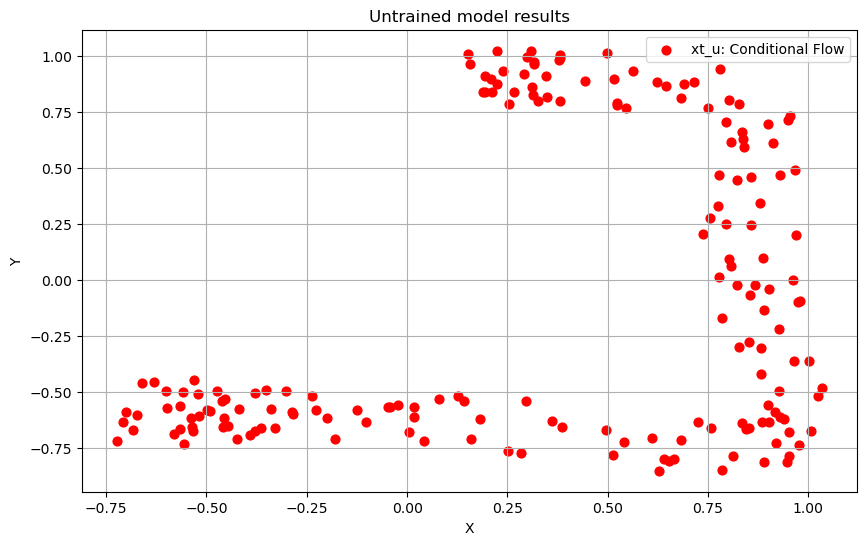

In [36]:
sigma = 0.08

for batch in dataLoader:
    observations = batch['observations'].to(device)
    print(observations.shape)
    print(observations[0].shape)

    x1 = observations
    x0 = torch.rand_like(x1).to(device)
    
    # t = torch.rand((x1.shape[0],), device=device)
    t = torch.ones((x1.shape[0],), device=device)

    t, xt, ut = sample_and_compute(x0, x1, t, sigma)
    break

print(f"xt[0] shape: {xt[0].shape}")

if isinstance(xt, torch.Tensor):
    xt = xt.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(xt[0, :, 0], xt[0, :, 1], color='red', alpha=1, s=40, label='xt_u: Conditional Flow', zorder=1)
plt.title("Untrained model results")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show

In [3]:
def show_untrained_model(sigma_init, dataLoader, device=device, obs_dim=2):
    sigma = sigma_init # How much noise is added when interpolating, calculated earlier
    
    print("Initial sigma:", sigma_init)

    flow_model = TrajectoryFlowModel(obs_dim).to(device)

    for batch in tqdm(dataLoader, desc=f"Training Progress"):
        observations = batch['observations'].to(device)
        x1 = observations
        x0 = torch.rand_like(x1).to(device)
        t = torch.rand((x1.shape[0],), device=device)

        t, xt, ut = sample_and_compute(x0, x1, t, sigma)

        t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
        xt = torch.cat([xt, t_expanded], dim=-1).to(device, dtype=torch.float32)
        
        vt = flow_model(xt)

    return vt, xt, ut

vt_u, xt_s, ut_u = show_untrained_model(sigma_init, dataLoader)

NameError: name 'sigma_init' is not defined

xt_u shape (64, 156, 5), vel pred shape (64, 156, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

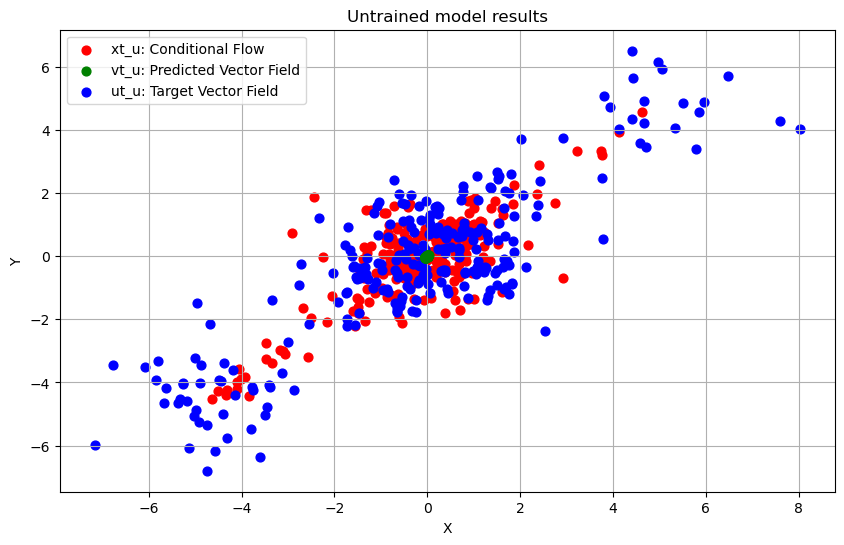

In [22]:
if isinstance(xt_u, torch.Tensor):
    xt_u = xt_u.cpu().numpy()
if isinstance(ut_u, torch.Tensor):
    ut_u = ut_u.detach().cpu().numpy()
if isinstance(vt_u, torch.Tensor):
    vt_u = vt_u.detach().cpu().numpy()

print(f"xt_s shape {xt_u.shape}, vel pred shape {vt_u.shape}")

plt.figure(figsize=(10, 6))
plt.scatter(xt_u[:, 0], xt_u[:, 1], color='red', alpha=1, s=40, label='xt_u: Conditional Flow', zorder=1)
plt.scatter(vt_u[:, 0], vt_u[:, 1], color='green', alpha=1, s=40, label='vt_u: Predicted Vector Field', zorder=2)
plt.scatter(ut_u[:, 0], ut_u[:, 1], color='blue', alpha=1, s=40, label='ut_u: Target Vector Field', zorder=1)
plt.title("Untrained model results")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show

In [37]:
def show_semi_trained_model(sigma_init, dataLoader):
    sigma = sigma_init # How much noise is added when interpolating, calculated earlier
    
    print("Initial sigma:", sigma_init)

    traj_dim = 4 # [xpos, ypos, xvel, yvel]
    flow_model = TrajectoryFlowModel(traj_dim).to(device)
    for i in range(1):
        for batch in tqdm(dataLoader, desc=f"Training Progress"):
            observations = batch['observations'].to(device)
            x1 = observations
            x0 = torch.rand_like(x1).to(device)
            t = torch.rand((x1.shape[0],), device=device)

            t, xt, ut = sample_and_compute(x0, x1, t, sigma)

            t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
            xt = torch.cat([xt, t_expanded], dim=-1).to(device, dtype=torch.float32)
            
            vt = flow_model(xt)
            loss = torch.mean((vt - ut) ** 2)
            
            loss = loss.to(device, dtype=torch.float32)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return vt, xt, ut

vt_s, xt_s, ut_s = show_semi_trained_model(sigma_init, dataLoader)

Initial sigma: 1.5903155522313102


Training Progress: 100%|██████████| 206/206 [04:05<00:00,  1.19s/it]


xt_s shape (64, 182, 5), vel pred shape (64, 182, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

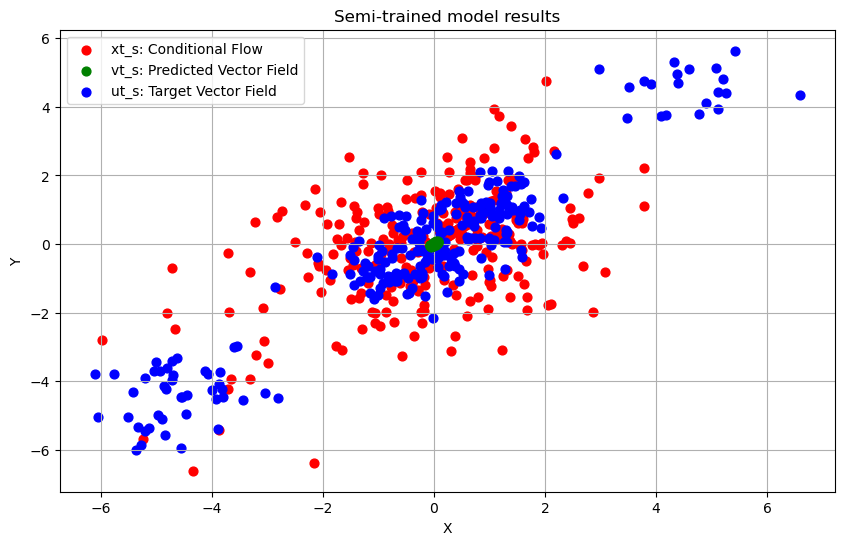

In [38]:
if isinstance(xt_s, torch.Tensor):
    xt_s = xt_s.cpu().numpy()
if isinstance(ut_s, torch.Tensor):
    ut_s = ut_s.detach().cpu().numpy()
if isinstance(vt_s, torch.Tensor):
    vt_s = vt_s.detach().cpu().numpy()

print(f"xt_s shape {xt_s.shape}, vel pred shape {vt_s.shape}")

plt.figure(figsize=(10, 6))
plt.scatter(xt_s[:, 0], xt_s[:, 1], color='red', alpha=1, s=40, label='xt_s: Conditional Flow', zorder=1)
plt.scatter(vt_s[:, 0], vt_s[:, 1], color='green', alpha=1, s=40, label='vt_s: Predicted Vector Field', zorder=2)
plt.scatter(ut_s[:, 0], ut_s[:, 1], color='blue', alpha=1, s=40, label='ut_s: Target Vector Field', zorder=1)
plt.title("Semi-trained model results")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show

## Training Loop

In [23]:
num_epochs = 20
sigma = sigma_init # How much noise is added when interpolating, calculated earlier
lr = 3e-3
traj_dim = 4 # [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
save_path = "fm_model_checkpoint_u20_larger_model.pth"

def train(flow_model, dataLoader, sigma, num_epochs, lr, device=device, save_path=save_path):
    optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)

    losses = []

    for epoch in range(num_epochs):
        for batch in tqdm(dataLoader, desc=f"Training Progress"):
            observations = batch['observations'].to(device)
            x1 = observations
            x0 = torch.rand_like(x1).to(device)
            t = torch.rand((x1.shape[0],), device=device)

            t, xt, ut = sample_and_compute(x0, x1, t, sigma)

            t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
            xt = torch.cat([xt, t_expanded], dim=-1).to(device, dtype=torch.float32)
            
            vt = flow_model(xt) # Eq 13/14 Lipman 2023

            loss = torch.mean((vt - ut) ** 2)
            
            loss = loss.to(device, dtype=torch.float32)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

        # Save checkpoint after each epoch
        checkpoint = {
            'model_state_dict': flow_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            'learning_rate': lr,
            'sigma': sigma,
            'xt' : xt,
            'vt': vt,
            'ut' : ut
        }

        torch.save(checkpoint, save_path)
        print(f"Checkpoint saved to {save_path} after epoch {epoch + 1}")

        
    print("\nLosses:\n")
    display_losses(losses)


In [24]:
# train(flow_model, dataLoader, sigma, num_epochs, lr)

## Load Model from Checkpoint

In [25]:
checkpoint = torch.load(save_path, map_location=device)

flow_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint.get('losses', [])
lr = checkpoint['learning_rate']
sigma = checkpoint['sigma']
vt = checkpoint['vt']
xt = checkpoint['xt']
ut = checkpoint['ut']

print("Checkpoint loaded successfully!")

Checkpoint loaded successfully!


First epoch:


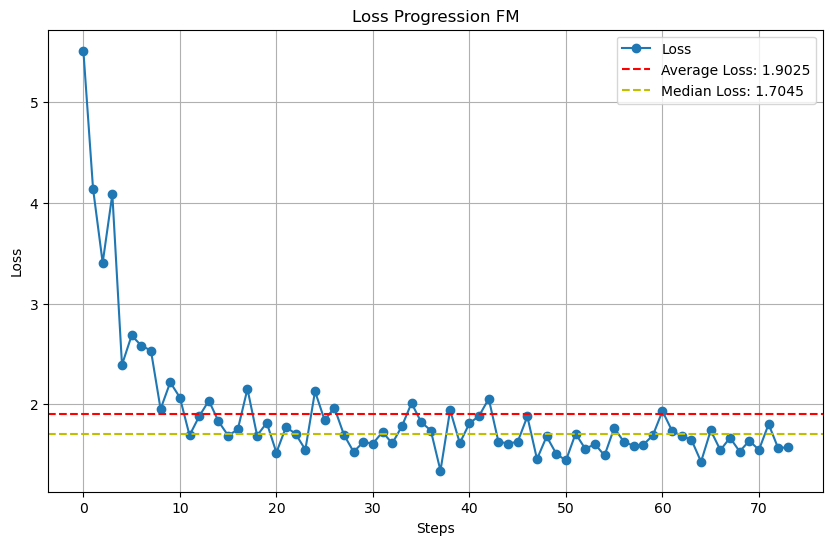

Last epoch:



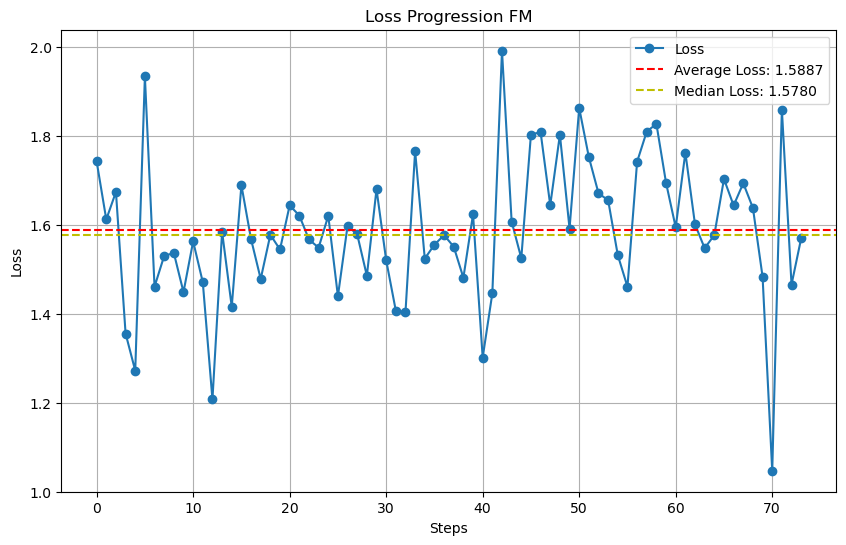

In [26]:
print("First epoch:")
first_loss = losses[:74]
display_losses(first_loss)
print("Last epoch:\n")
last_loss = losses[-74:]
display_losses(last_loss)

## Display Functionality

xt shape (64, 178, 5), vel pred shape (64, 178, 4), ut shape (64, 178, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

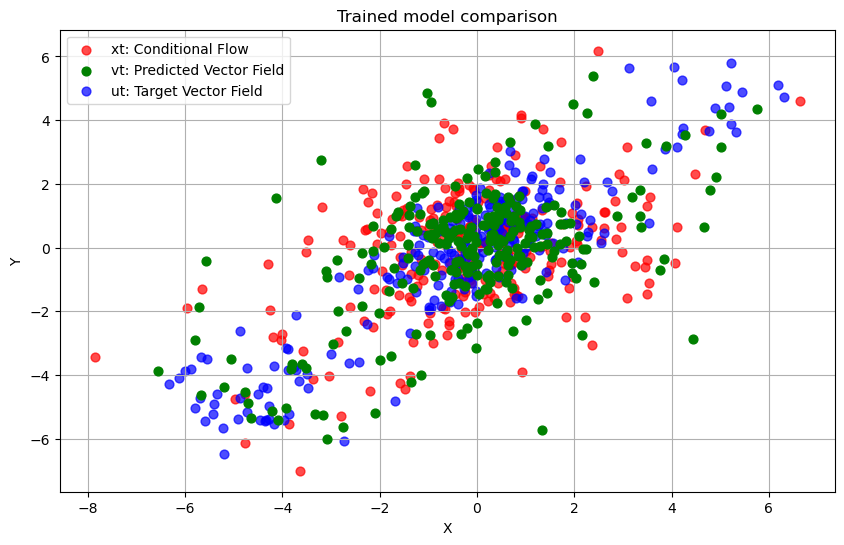

In [27]:
if isinstance(xt, torch.Tensor):
    xt = xt.cpu().numpy()
if isinstance(ut, torch.Tensor):
    ut = ut.detach().cpu().numpy()
if isinstance(vt, torch.Tensor):
    vt = vt.detach().cpu().numpy()

print(f"xt shape {xt.shape}, vel pred shape {vt.shape}, ut shape {ut.shape}")

plt.figure(figsize=(10, 6))
plt.scatter(xt[:, 0], xt[:, 1], color='red', alpha=0.7, s=40, label='xt: Conditional Flow', zorder = 1)
plt.scatter(vt[:, 0], vt[:, 1], color='green', alpha=1, s=40, label='vt: Predicted Vector Field', zorder = 2)
plt.scatter(ut[:, 0], ut[:, 1], color='blue', alpha=0.7, s=40, label='ut: Target Vector Field', zorder = 1) 
plt.title("Trained model comparison")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show

## Sampling

In [28]:
class torch_wrapper(nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):

        # t is [] going in, so we use torch.full to create the correct shape and fill it.

        t_expanded = torch.full((x.shape[0], x.shape[1], 1), t.item(), device=x.device, dtype=x.dtype)
        xt = torch.cat([x, t_expanded], dim=-1)  # Concatenating time to match model input

        return self.model(xt)

In [29]:
def single_gaussian_sample_alt(batch_size, sec_dim, traj_dim, sigma, device=device, var=1.0):
    """
    Generate samples from a single Gaussian distribution centered at the origin.

    Args:
        batch_size (int): Number of batches.
        sec_dim (int): Number of sections (sequence length).
        traj_dim (int): Dimensionality of each trajectory point.
        var (float): Variance of the Gaussian distribution.

    Returns:
        torch.Tensor: Tensor of shape (n, dim) containing sampled points.
    """

    return torch.randn(batch_size, sec_dim, traj_dim, device=device, dtype=torch.float32) * var**0.5

In [30]:
def plot_trajectories(traj, sec_dim, observation_lst):
    """Plot trajectories of some selected samples."""
    n = sec_dim
    plt.figure(figsize=(8, 8))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black", label="Noisy Sample")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.35, alpha=0.2, c="red", label="Flow")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue", label="Target Sample")

    # for observations in observation_lst:
    #     plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)

    # for observations in observation_lst:
    #     plt.scatter(
    #         observations[0, :, 0].cpu().numpy(),  # X positions
    #         observations[0, :, 1].cpu().numpy(),  # Y positions
    #         color='g', 
    #         alpha=0.5,
    #         s=1  # Adjust point size if needed
    #     )

    
    plt.legend()
    plt.title("Flow Matching Evolution")
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [31]:
def sample(flow_model, batch_size, shape, sigma, traj_dim=4, num_steps=10000, solver="euler"):
    
    node = NeuralODE(
        torch_wrapper(flow_model),
        solver=solver,
        sensitivity="adjoint",
        atol=1e-4,
        rtol=1e-4
    )

    with torch.no_grad():
        traj = node.trajectory(
            single_gaussian_sample_alt(batch_size, shape, traj_dim, sigma),
            t_span = torch.linspace(0, 1, num_steps, device=device, dtype=torch.float32),
        )
    return traj # traj[-1]

/cluster/home/mortenhs/.conda/envs/fm_env/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")
/cluster/home/mortenhs/.conda/envs/fm_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


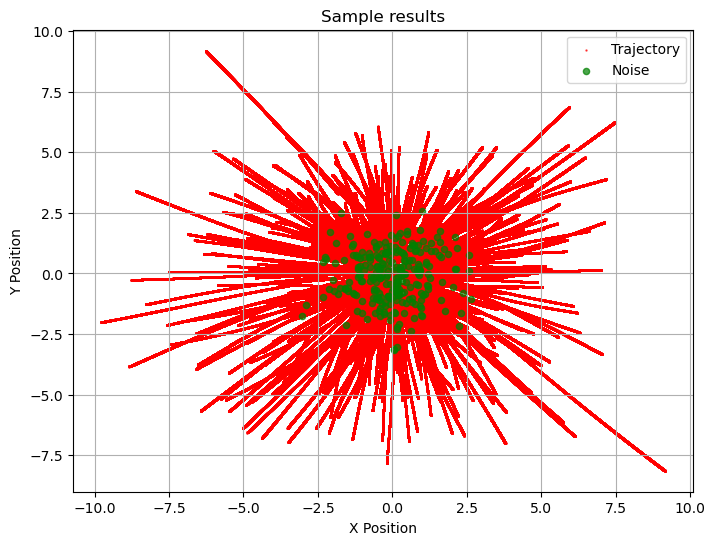

In [32]:
shape = xt.shape[1]
traj = sample(flow_model, batch_size, shape, sigma)

sg = single_gaussian_sample_alt(batch_size, shape, traj_dim, sigma)
sg = sg.cpu().numpy()

# xpos = traj[-1][0][:, 0].cpu().numpy()
# ypos = traj[-1][0][:, 1].cpu().numpy()

xpos = traj[:, 0].cpu().numpy()
ypos = traj[:, 1].cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(xpos, ypos, marker='o', s=0.5, color='red', alpha=0.7, label="Trajectory")
plt.scatter(sg[:, 0], sg[:, 1], marker='o', color='g', s=20, alpha=0.7, label='Noise')
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Sample results")
plt.legend(loc='upper right')
plt.grid()
plt.show()

torch.Size([10000, 64, 178, 4])
torch.Size([64, 178, 4])
torch.Size([178, 4])


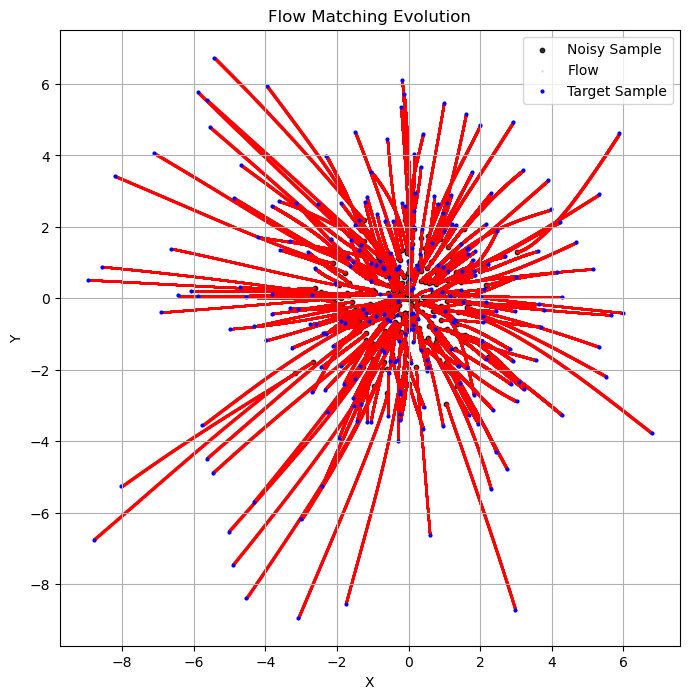

In [33]:
# Må ta inn t og x, istedenfor xt virker det som.
shape = xt.shape[1]
traj = sample(flow_model, batch_size, shape, sigma)

print(traj.shape)
print(traj[-1].shape)
print(traj[-1][0].shape)

plot_trajectories(traj.cpu().numpy(), shape, observation_lst)